# Multi-Stage Heatmap Regression

Hello everyone! In this notebook I will be sharing with you guys what I learned in keypoint detection using neural networks. I am currently doing some research into the human pose estimation problem and thought it would be fun to use what I learned on this simple dataset.

The challenge presented with this dataset is to figure out the Cartesian (x,y) coordinates of keypoints in facial images. Some of these keypoints include: left_eye_center, right_eye_center, etc... The simplest approach with deep learning is to try and directly map image input to Cartesian coordinates output. This idea was first introduced by Toshev et al. in his scientific paper about the DeepPose network. However, people have speculated that the direct mapping from image to Cartesian coordinates is really complex and hence any model with sufficient accuracy will also be likely to overfit and not generalize well to new data.

Introduce heatmap regression, in which the problem gets slightly changed. Instead of predicting Cartesian coordinates, we will be building a deep net to predict a different heatmap for every keypoint we want to find. A heatmap is simply just a picture that shows the likelyhood of a specific keypoint residing at that pixel. Please follow along this notebook to learn more!

In [1]:
#Imports
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers import *
from keras.models import *
from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


# Step 1: Loading in the data

In [2]:
#Read in data
df = pd.read_csv('/kaggle/input/facial-keypoints-detection/training/training.csv')
df.fillna(method = 'ffill',inplace = True)

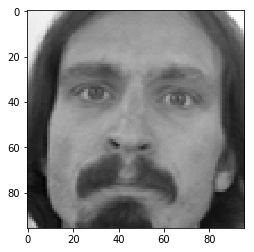

In [3]:
#Transform the data into images and plot one to see

imgs = []
for i in range(0,7049):
    img = df['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imgs.append(img)


image_list = np.array(imgs,dtype = 'float')
X_train = image_list.reshape(-1,96,96,1)
plt.imshow(X_train[0].reshape(96,96),cmap='gray')
plt.show()

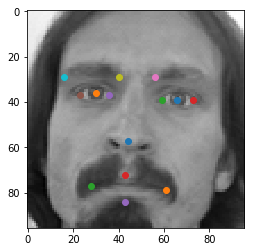

In [4]:
#Get the keypoint labels
training = df.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

#Plot labels ontop of image
img = X_train[0].copy()
for i in range(0, len(y_train[0])-1, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i+1])
    plt.scatter(x,y)
plt.imshow(img.reshape(96,96),cmap='gray')

# Step 2: Creating the Heatmaps

Okay, so like I said before, we are going to be predicting heatmaps with our model. So how do we actually get our labelled heatmap data? Turns out it is actually quite easy, we simply pass our Cartesian coordinates through a 2D gaussian kernel.

In [5]:
#Function to create heatmaps by convoluting a 2D gaussian kernel over a (x,y) keypoint.
def gaussian(xL, yL, H, W, sigma=5):

    channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
    channel = np.array(channel, dtype=np.float32)
    channel = np.reshape(channel, newshape=(H, W))

    return channel

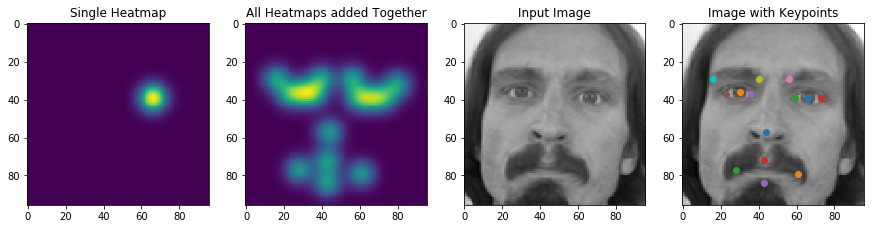

(15, 96, 96)

In [6]:
#Generate heatmaps for one sample image
heatmaps = []

for i in range(0, 30, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i + 1])
    heatmap = gaussian(x, y, 96, 96)
    heatmaps.append(heatmap)
    
heatmaps = np.array(heatmaps)

plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(heatmaps[0])
plt.title("Single Heatmap")

plt.subplot(1,4,2)
plt.imshow(heatmaps.sum(axis=0))
plt.title("All Heatmaps added Together")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(X_train[0], axis=2), cmap='gray')
plt.title("Input Image")

plt.subplot(1,4,4)
for i in range(0, len(y_train[0])-1, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i+1])
    plt.scatter(x,y)
plt.imshow(X_train[0].reshape(96,96), cmap='gray')
plt.title("Image with Keypoints")
plt.show()

heatmaps.shape

So according to our dataset, each input image has 15 keypoints associated with it. Therefore each image is also going to have 15 heatmaps, one heatmap for each facial keypoint. As you can see from the pictures above, the areas of the heatmap that are more yellow represent pixels that are more likely for a keypoint location to be.

# Step 3: Keras Custom Generator

Here we are going to create a custom keras generator to yield batches of our heatmap data on-the-fly during training. Alternatively, we could create all the heatmaps before hand and then just pass them into a machine learning model, but the heatmaps take up a lot of memory and we don't really care about keeping these heatmaps after training is finished.

Generators are a very important concept to learn for other machine learning problems, when your dataset is too big to fit into memory. I am going to teach you guys how to build your own custom generator that fits into your Keras framework.

Most of the information I will be sharing with you guys came from this link <a href="https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly">here</a>. Please take a look at their explanation as it is wayyyy better than mine :p

Alright, so first of all we are going to be creating a new Python class that inherits from **keras.utilities.Sequence**, which gives us nice functionality like multiprocessing.

To make a generator that inherits the **keras.utilities.Sequence** class we need to create the following methods:
- ```__init__()```: this is your basic initialization method.
- ```on_epoch_end()```: this method is triggered every time your generator runs through one epoch of your data. Typically you would want to shuffle your dataset using this method.
- ```__data_generation()```: this is the method that actually does the data processing. In here you will create your batch of data.
- ```__len__()```: this method is used to tell the generator how many batches of data would be needed to complete one full epoch, it returns a number between 0 and the total number of batches. This number is passed into your other methods, typically called index.
- ```__get_item__()```: this method is the one that actually returns your batch of data.

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, imgs, kps, batch_size=32, shuffle=True):
        self.imgs = imgs
        self.kps = kps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.imgs) // self.batch_size

    def __getitem__(self, index):
        #Get index of images to generate
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        #Shuffle the data after the generator has run through all samples
        self.indexes = np.arange(len(self.imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def gaussian(self, xL, yL, H, W, sigma=5):
        ##Function that creates the heatmaps##
        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X_batch = [self.imgs[i] for i in indexes]
        X_batch = np.array(X_batch)
        
        y_batch = []
        
        kps = [self.kps[i] for i in indexes]
        
        for i in range(0,len(kps)):
            heatmaps = []
            for j in range(0, 15):
                x = int(kps[i][j*2])
                y = int(kps[i][j*2+1])
                heatmap = self.gaussian(x, y, 96, 96)
                heatmaps.append(heatmap)
            y_batch.append(heatmaps)
                
        y_batch = np.array(y_batch)
        y_batch = np.swapaxes(y_batch,1,3)
        y_batch = np.swapaxes(y_batch,1,2)
        return X_batch, [y_batch, y_batch]

(32, 96, 96, 1)
(32, 96, 96, 15)


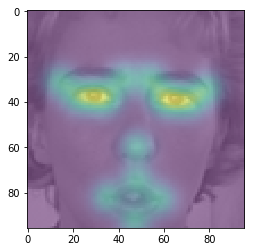

In [8]:
#Testing to see if our DataGenerator is working
X_batch, [y_batch, _] = next(DataGenerator(X_train, y_train).__iter__())
print(X_batch.shape)
print(y_batch.shape)

#Plot a single image overlayed with its heatmaps
plt.imshow(X_batch[0].reshape(96,96), cmap='gray', alpha=0.5)
plt.imshow(y_batch[0].sum(axis=2), alpha=0.5)

If you made it this far, you might have noticed that my DataGenerator actually yields two sets of y_batch. This was done on purpose because we are going to be using a two-stage heatmap regression approach, with intermediate training. I got this idea from the <a href="https://arxiv.org/pdf/1602.00134.pdf">Convolutional Pose Machines paper</a>. This concept is similar to traditional boosting algorithms in which the main idea is to learn from the mistakes of the first output. Basically, every stage is going to predict a heatmap and the next stage will use the previous stage's heatmap prediction along with the input image to create a new, more accurate prediction.

One thing we need to clarify is **intermediate training**. The more stages you make the model, the more layers it is going to have, hence your model might run into the Vanishing Gradient Problem. To combat this, we will be using intermediate training in which the total loss of the model is the summation of each individual stage's loss.

Here is a high level picture of how the multi-stage model works:
![](https://i.imgur.com/xbtp8tC.png)

# Step 4: Creating the Model

In this step we are actually going to make our model. It is a traditional fully convolutional network which I added two stages and trained using intermediate training.

In [9]:
#Helper function for building model
def conv_block(x, nconvs, n_filters, block_name, wd=None):
    for i in range(nconvs):
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   kernel_regularizer=wd, name=block_name + "_conv" + str(i + 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name=block_name + "_pool")(x)
    return x
  
#Represents one stage of the model
def stages(x, stage_num, num_keypoints = 15):
  
    #Block 1
    x = conv_block(x, nconvs=2, n_filters=64, block_name="block1_stage{}".format(stage_num))
  
    #Block 2
    x = conv_block(x, nconvs=2, n_filters=128, block_name="block2_stage{}".format(stage_num))
  
    #Block 3
    pool3 = conv_block(x, nconvs=3, n_filters=256, block_name="block3_stage{}".format(stage_num))
  
    #Block 4
    pool4 = conv_block(pool3, nconvs=3, n_filters=512, block_name="block4_stage{}".format(stage_num))
  
    #Block 5
    x = conv_block(pool4, nconvs=3, n_filters=512, block_name="block5_stage{}".format(stage_num))
  
    #Convolution 6
    x = Conv2D(4096, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv6_stage{}".format(stage_num))(x)
  
    #Convolution 7
    x = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv7_stage{}".format(stage_num))(x)

    #upsampling
    preds_pool3 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool3_stage{}".format(stage_num))(pool3)
    preds_pool4 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool4_stage{}".format(stage_num))(pool4)
    up_pool4 = Conv2DTranspose(filters=15, kernel_size=2, strides=2, activation='relu', name="ConvT_pool4_stage{}".format(stage_num))(preds_pool4)
    up_conv7 = Conv2DTranspose(filters=15, kernel_size=4, strides=4, activation='relu', name="ConvT_conv7_stage{}".format(stage_num))(x)
  
    fusion = Add()([preds_pool3, up_pool4, up_conv7])
  
    heatmaps = Conv2DTranspose(filters=15, kernel_size=8, strides=8, activation='relu', name="convT_fusion_stage{}".format(stage_num))(fusion)
    heatmaps = Conv2D(num_keypoints, kernel_size=(1, 1), strides=1, padding="same", activation="linear", name="output_stage{}".format(stage_num))(heatmaps)
    return heatmaps
  
#Create a single stage FCN
def build_model(input_shape):
    outputs = []
  
    img = Input(shape=input_shape, name="Input_stage")
  
    ### Stage 1 ###
    heatmaps1 = stages(img, 1)
    outputs.append(heatmaps1)
  
    ### Stage 2 ###
    x = Concatenate()([img, heatmaps1])
    heatmaps2 = stages(x, 2)
    outputs.append(heatmaps2)
  
    model = Model(inputs=img, outputs=outputs, name="FCN_Final")
    return model

In [10]:
#Training the model using mean squared losss
def get_loss_func():
    def mse(x, y):
        return mean_squared_error(x,y)
  
    keys = ['output_stage1', 'output_stage2']
    losses = dict.fromkeys(keys, mse)
    return losses

model = build_model((96,96,1))
losses = get_loss_func()
model.compile(loss = losses, optimizer = 'adam')
model.summary()

Model: "FCN_Final"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_stage (InputLayer)        (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
block1_stage1_conv1 (Conv2D)    (None, 96, 96, 64)   640         Input_stage[0][0]                
__________________________________________________________________________________________________
block1_stage1_conv2 (Conv2D)    (None, 96, 96, 64)   36928       block1_stage1_conv1[0][0]        
__________________________________________________________________________________________________
block1_stage1_pool (MaxPooling2 (None, 48, 48, 64)   0           block1_stage1_conv2[0][0]        
__________________________________________________________________________________________

# Step 5: Training the Model

In [11]:
#First, lets split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

#Create your two generators for train and validation
gen_train = DataGenerator(X_train, y_train)
gen_val = DataGenerator(X_val, y_val)

#Train the model
model.fit_generator(generator = gen_train,
                    epochs = 10,
                    validation_data = gen_val)

Epoch 1/10
165/165 [==============================] - 1101s 7s/step - loss: 0.0958 - output_stage1_loss: 0.0843 - output_stage2_loss: 0.0114 - val_loss: 0.0161 - val_output_stage1_loss: 0.0082 - val_output_stage2_loss: 0.0079
Epoch 2/10
165/165 [==============================] - 1059s 6s/step - loss: 0.0155 - output_stage1_loss: 0.0081 - output_stage2_loss: 0.0074 - val_loss: 0.0150 - val_output_stage1_loss: 0.0080 - val_output_stage2_loss: 0.0069
Epoch 3/10
165/165 [==============================] - 1053s 6s/step - loss: 0.0143 - output_stage1_loss: 0.0079 - output_stage2_loss: 0.0064 - val_loss: 0.0138 - val_output_stage1_loss: 0.0078 - val_output_stage2_loss: 0.0059
Epoch 4/10
165/165 [==============================] - 1049s 6s/step - loss: 0.0132 - output_stage1_loss: 0.0077 - output_stage2_loss: 0.0055 - val_loss: 0.0128 - val_output_stage1_loss: 0.0076 - val_output_stage2_loss: 0.0052
Epoch 5/10
165/165 [==============================] - 1043s 6s/step - loss: 0.0124 - output_stag

Text(0.5, 1.0, 'Stage 2 Prediction')

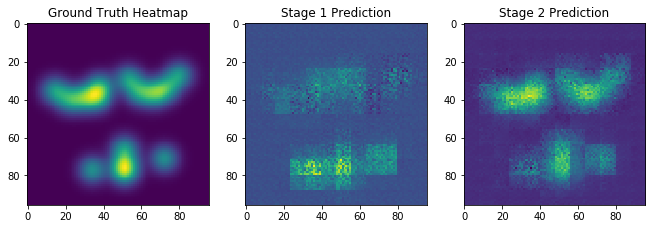

In [12]:
X_batch, [y_batch, _] = next(gen_val.__iter__())

index = np.random.randint(0,32)

predictions = model.predict(X_batch)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(y_batch[index].sum(axis=2))
plt.title("Ground Truth Heatmap")

plt.subplot(1,4,2)
plt.imshow(predictions[0][index].sum(axis=2))
plt.title("Stage 1 Prediction")

plt.subplot(1,4,3)
plt.imshow(predictions[1][index].sum(axis=2))
plt.title("Stage 2 Prediction")

So as you can see our second stage looks a lot better than our first stage!